
# Proyecto DS — Entrega 1: Análisis exploratorio de datos de Fórmula 1 (2019–2024)

**Abstract**

Este proyecto se centra en el análisis exploratorio de datos de la Fórmula 1 correspondientes al período 2019–2024, con el objetivo de identificar patrones de rendimiento de pilotos y escuderías en distintos contextos competitivos. El dataset reúne información estructurada y organizada a partir de fuentes públicas y confiables, tales como el sitio oficial formula1.com, la base estadística statsf1.com y el repositorio colaborativo formula1-datasets en GitHub. La base de datos contempla las principales entidades del campeonato, incluyendo pilotos, equipos y circuitos, así como los resultados obtenidos en diferentes modalidades de competencia: sesiones de clasificación, carreras principales y carreras Sprint. Entre las variables disponibles se destacan posiciones de largada y finalización, vueltas rápidas, puntos, tiempos y desempeño acumulado por temporada.

El interés central del proyecto radica en comprobar si el rendimiento en la Fórmula 1 está determinado principalmente por la calidad de la escudería y la destreza del piloto, y cómo estas variables interactúan en escenarios diversos como circuitos de distinta longitud, condiciones de carrera y formatos de competencia. El análisis contempla la detección de tendencias de mejora, estabilidad o retroceso en el desempeño de pilotos y equipos, permitiendo explorar la consistencia a lo largo de las temporadas y los factores que explican la variación en los resultados. Asimismo, se busca examinar el rol de características específicas de los circuitos sobre los resultados deportivos, y establecer correlaciones entre indicadores clave como posiciones de largada, vueltas rápidas, podios, puntos y posiciones finales.

El alcance de esta primera etapa incluye la exploración de datos estructurados correspondientes únicamente a los aspectos deportivos de la Fórmula 1, sin considerar variables externas como condiciones climáticas, sanciones administrativas o factores estratégicos relacionados con neumáticos o estrategias de boxes. El proyecto se apoya en el uso de técnicas de visualización y análisis exploratorio en Python, priorizando representaciones univariadas, bivariadas y multivariadas que permitan contrastar las hipótesis planteadas. De esta manera, se pretende no solo describir el rendimiento histórico de la F1 en el período de estudio, sino también construir una base sólida para investigaciones posteriores en el ámbito del deporte motor, que podrían incorporar modelos predictivos y factores contextuales más complejos.



## Preguntas e hipótesis de interés

**Preguntas principales**:
1. ¿Qué equipos muestran un mayor dominio en términos de puntos acumulados por temporada?
2. ¿Existe una relación entre la posición de largada en clasificación y el resultado final en carrera?
3. ¿Qué pilotos concentran la mayoría de los podios entre 2019 y 2024?
4. ¿Qué relación hay entre vueltas rápidas y puntos obtenidos en carrera?
5. ¿Cómo evolucionaron los equipos en términos de podios, poles y puntos a lo largo de 2019–2024?

**Hipótesis**:
- H1: Los equipos con mayor número de pole positions tienden a acumular más puntos en la temporada.
- H2: La posición de salida en la grilla (qualifying) está fuertemente correlacionada con la posición final en la carrera.
- H3: Los pilotos que obtienen la vuelta rápida en una carrera tienen mayor probabilidad de finalizar en los puntos (Top 10).
- H4: Un pequeño grupo de pilotos acumula la mayoría de los podios en el período 2019–2024, mientras que la mayoría obtiene pocos o ningún podio.
- H5: El rendimiento de ciertos equipos se mantiene estable entre temporadas, mientras que otros muestran una tendencia de mejora o retroceso.

A continuación se implementarán análisis y gráficos que combinan variables para diagnosticar estas preguntas.


In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

archivo = "Exploración Estadística de la Fórmula 1 (2019–2024).xlsx"

hojas = ["Tracks", "Qualifying", "Sprints", "Races", "Drivers", "Teams", "Status"]

# Diccionario de DataFrames 
dfs = {}

# Carga todas las hojas y limpia nombres de columnas
for hoja in hojas:
    df = pd.read_excel(archivo, sheet_name=hoja)
    df.columns = df.columns.str.strip()  
    dfs[hoja] = df

# Variables individuales
df_races = dfs["Races"]
df_drivers = dfs["Drivers"]
df_teams = dfs["Teams"]
df_sprints = dfs["Sprints"]
df_tracks = dfs["Tracks"]
df_qualifying = dfs["Qualifying"]
df_status = dfs["Status"]

# Races
df_races['Finished'] = df_races['race_end_position'].notna()  # True si terminó
df_races['HasFastestLap'] = df_races['race_fastestLapTime'].notna()  # True si tiene tiempo de vuelta
df_races['GridAvailable'] = df_races['race_starting_grid'].notna()  # True si hay posición de largada

# Sprints
df_sprints['SQ2_Participated'] = df_sprints['SQ2'].notna()
df_sprints['SQ3_Participated'] = df_sprints['SQ3'].notna()

# Qualifying
df_qualifying['Q1_Participated'] = df_qualifying['Q1'].notna()
df_qualifying['Q2_Participated'] = df_qualifying['Q2'].notna()
df_qualifying['Q3_Participated'] = df_qualifying['Q3'].notna()
df_qualifying['Quali_Position_Available'] = df_qualifying['Quali_Position'].notna()

# Muestra información general de cada hoja y detecta valores faltantes
for hoja, df in dfs.items():
    print(f"--- Hoja: {hoja} ---")
    print(f"Filas x Columnas: {df.shape}")
    print("Valores faltantes por columna:")
    print(df.isna().sum())
    print("\n")



--- Hoja: Tracks ---
Filas x Columnas: (129, 19)
Valores faltantes por columna:
Season                 0
Track_ID               0
Race_ID                0
Round                  0
Country_ID             0
Country                0
City                   0
Circuit Name           0
GP Name                0
Race Date              0
First Grand Prix       0
Number of Laps         0
Circuit Length (Km)    0
Race Distance (Km)     0
Lap Record             0
Record Owner           0
Record Year            0
Turns                  0
DRS Zones              0
dtype: int64


--- Hoja: Qualifying ---
Filas x Columnas: (2579, 19)
Valores faltantes por columna:
Season                         0
Driver_SeasonID                0
Race ID                        0
Country_ID                     0
Car_Number                     0
Driver_ID                      0
Team                           0
Team_SeasonID                  0
Q1                             8
Q2                           648
Q3             

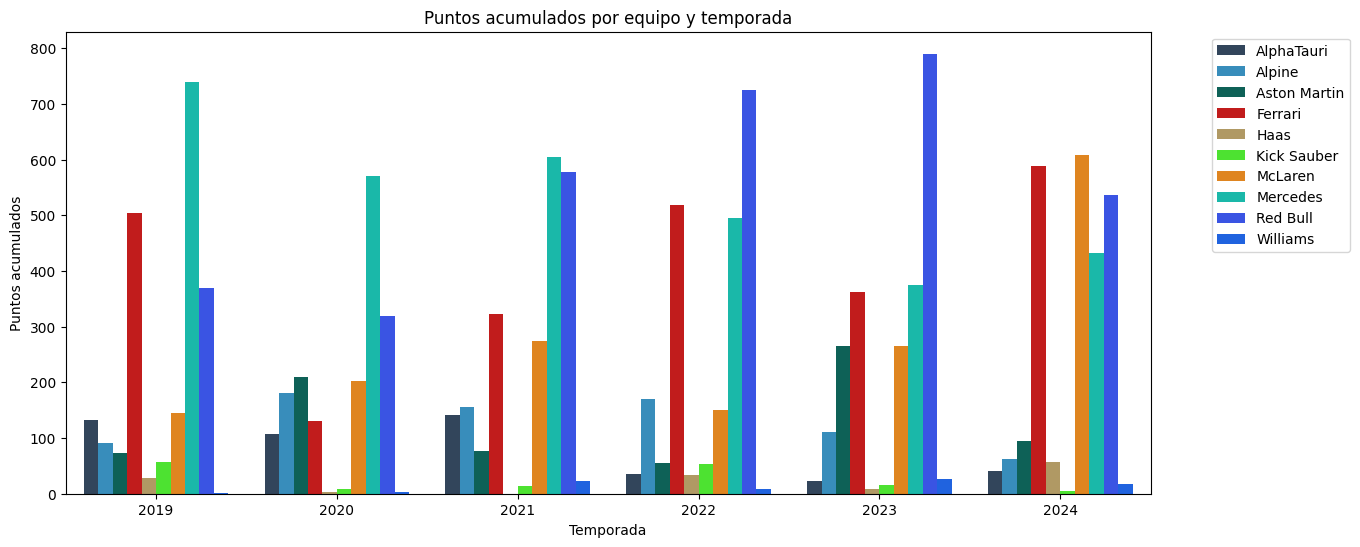

Equipo,total,promedio,max,min
Red Bull,3318.5,553.1,790.0,319.0
Mercedes,3215.5,535.9,739.0,374.0
Ferrari,2428.5,404.8,589.0,131.0
McLaren,1646.0,274.3,609.0,145.0
Aston Martin,775.0,129.2,266.0,55.0
Alpine,770.0,128.3,181.0,63.0
AlphaTauri,478.0,79.7,142.0,22.0
Kick Sauber,151.0,25.2,57.0,4.0
Haas,130.0,21.7,57.0,0.0
Williams,78.0,13.0,26.0,1.0


In [30]:
# Merge para traer el nombre genérico del equipo
df_races_merged = pd.merge(df_races, df_teams[['Team_SeasonID','Team']], on='Team_SeasonID', how='left')

# Con esto agrupo por Season y Team (nombre genérico) para sumar puntos
df_team_points = df_races_merged.groupby(['Season', 'Team'])['race_points'].sum().reset_index()

df_team_points = df_team_points.rename(columns={'Team':'Equipo'})

# Gráfico de barras
# Diccionario con colores emblemáticos de cada equipo
team_colors = {
    "Mercedes": "#00D2BE",
    "Red Bull": "#1E41FF",
    "Ferrari": "#DC0000",
    "McLaren": "#FF8700",
    "Alpine": "#2293D1",
    "AlphaTauri": "#2B4562",
    "Aston Martin": "#006F62",
    "Alfa Romeo": "#900000",
    "Williams": "#005AFF",
    "Haas": "#BD9E57",
    "Kick Sauber": "#39FF14"
}

plt.figure(figsize=(14,6))
sns.barplot(
    data=df_team_points,
    x='Season',
    y='race_points',
    hue='Equipo',
    palette=team_colors
)
plt.title("Puntos acumulados por equipo y temporada")
plt.ylabel("Puntos acumulados")
plt.xlabel("Temporada")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

df_team_summary = df_team_points.groupby('Equipo')['race_points'].agg(
    total='sum',
    promedio='mean',
    max='max',
    min='min'
).reset_index()

# Redondear el promedio
df_team_summary['promedio'] = df_team_summary['promedio'].round(1)

# Ordenar de mayor a menor según promedio
df_team_summary = df_team_summary.sort_values(by='promedio', ascending=False)

df_team_summary.style.hide(axis="index").format({
    'total': '{:.1f}',
    'promedio': '{:.1f}',
    'max': '{:.1f}',
    'min': '{:.1f}'
})


### 1️⃣ Puntos acumulados por equipo por temporada
**Pregunta:** ¿Qué equipos muestran un mayor dominio en términos de puntos acumulados por temporada?  
**Hipótesis:** Los equipos con más pole positions tienden a acumular más puntos en la temporada.  

**Interpretación:**  
- Mercedes, Red Bull y Ferrari concentran la mayoría de los puntos en cada temporada. 
- Se pueden observar fluctuaciones año a año que permiten determinar las mejoras o retrocesos de cada equipo.
- Equipos como Kick Sauber o Williams tienen contribuciones mínimas.


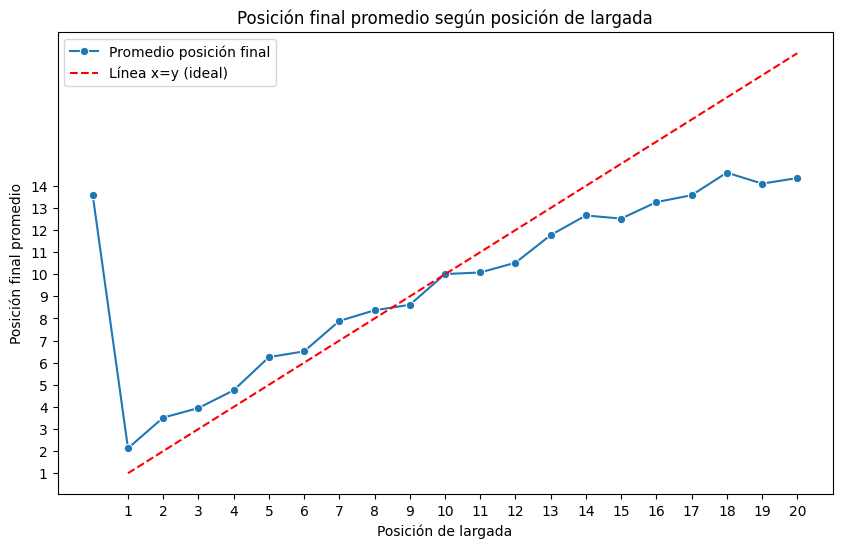

Posición de largada,Promedio posición final,Desviación estándar
1,2.13,2.04
2,3.52,3.69
3,3.95,3.07
4,4.75,3.13
5,6.25,3.85
6,6.51,3.25
7,7.89,3.61
8,8.37,3.38
9,8.62,3.38
10,10.01,3.84


In [31]:
df_avg = df_races.groupby('race_starting_grid')['race_end_position'].mean().reset_index()

plt.figure(figsize=(10,6)) 

# Línea azul: promedio 
sns.lineplot(
    data=df_avg,
    x='race_starting_grid',
    y='race_end_position',
    marker='o',
    label='Promedio posición final'
) 

# Línea roja: referencia x=y 
plt.plot([1,20],[1,20], color='red', linestyle='--', label='Línea x=y (ideal)') 

plt.title("Posición final promedio según posición de largada") 
plt.xlabel("Posición de largada") 
plt.ylabel("Posición final promedio") 
plt.legend() 

plt.xticks(np.arange(1, 21, 1))  
plt.yticks(np.arange(1, int(df_avg['race_end_position'].max()) + 1, 1))  

plt.show()

# Resumen de posición final según posición de largada (sin posición 0)
resumen = (
    df_races[df_races['race_starting_grid'] > 0]  
    .groupby('race_starting_grid')['race_end_position']
    .agg(promedio_posicion_final='mean', desviacion='std')
    .reset_index()
)

# Redondear a 2 decimales
resumen['promedio_posicion_final'] = resumen['promedio_posicion_final'].round(2)
resumen['desviacion'] = resumen['desviacion'].round(2)

# Renombrar columnas al español (me olvidé que tengo todo el excel en inglés)
resumen = resumen.rename(columns={
    'race_starting_grid': 'Posición de largada',
    'promedio_posicion_final': 'Promedio posición final',
    'desviacion': 'Desviación estándar'
})

# Convertir a entero
resumen['Posición de largada'] = resumen['Posición de largada'].astype(int)

# Mostrar tabla limpia, sin índice
resumen.style.hide(axis="index").format({
    "Promedio posición final": "{:.2f}",
    "Desviación estándar": "{:.2f}"
})




## 2️⃣ Posición final promedio vs posición de largada

**Pregunta:** ¿Existe relación entre la posición de largada y la posición final?  
**Hipótesis:** La posición de salida en la grilla está fuertemente correlacionada con la posición final en la carrera.  

**Interpretación del gráfico de líneas:**  
- Los pilotos que largan en primeras posiciones tienden a terminar adelante.
- El poleman (1º) finaliza en promedio 2,13º, con baja variabilidad (±2,04 puestos).
- Entre 2º y 4º, los promedios de llegada van de 3,52 a 4,75; del 5º al 9º, de 6,25 a 8,62, con mayor dispersión.
- Del 10º al 20º, los promedios de llegada aumentan de 10,01 a 14,35, con desviaciones entre ±3,33 y ±4,32, mostrando que los pilotos que largan más atrás tienen más incertidumbre en el resultado final.
- La línea roja x=y sirve de referencia: la correlación sigue siendo positiva pero no perfecta, ya que factores externos (estrategia, incidentes, clima) también influyen en el resultado final.


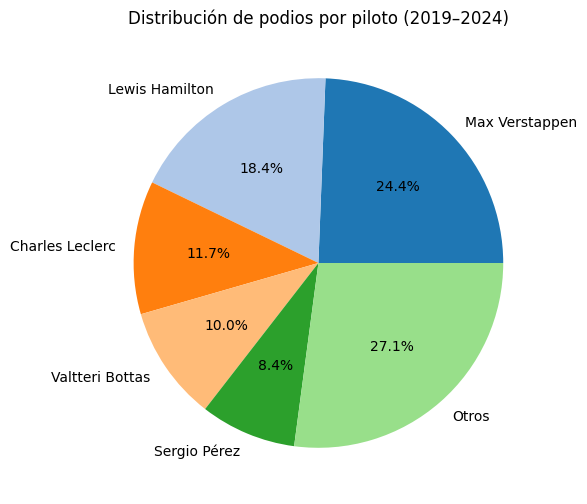

Total de podios: 2214
Top 5 pilotos: 1614 (72.9%)
Otros: 600 (27.1%)


In [32]:
# Filtrar solo podios (1º, 2º, 3º puesto)
df_podios = df_races[df_races['race_end_position'] <= 3]
df_podios = df_podios.merge(df_drivers[['Driver_ID', 'Driver_Name']], on='Driver_ID', how='left')

# Contar podios por piloto
podios_count = df_podios['Driver_Name'].value_counts()

# Top 5 pilotos + "Otros"
top5 = podios_count.nlargest(5)
otros = podios_count[~podios_count.index.isin(top5.index)].sum()
pie_data = pd.concat([top5, pd.Series({'Otros': otros})])

# Graficar
plt.figure(figsize=(6,6))
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', colors=plt.cm.tab20.colors)
plt.title("Distribución de podios por piloto (2019–2024)")
plt.show()

# Métricas
total_podios = podios_count.sum()
print("Total de podios:", total_podios)
print("Top 5 pilotos:", top5.sum(), f"({top5.sum()/total_podios:.1%})")
print("Otros:", otros, f"({otros/total_podios:.1%})")




## 3️⃣ Distribución de podios por piloto (Pie chart)

**Pregunta:** ¿Qué pilotos concentran la mayoría de los podios entre 2019 y 2024?  
**Hipótesis:** Un pequeño grupo de pilotos acumula la mayoría de los podios en el período analizado, mientras que la mayoría obtiene pocos o ningún podio.  

**Interpretación del pie chart:**  
- El período 2019–2024 registra 2214 podios en total.
- Los 5 pilotos más exitosos concentran 1614 podios (72.9%), lo que confirma su dominio sostenido.
- El resto de la parrilla suma apenas 600 podios (27.1%), quedando claramente relegados.
- Esto respalda la hipótesis de que el éxito en Fórmula 1 está altamente concentrado en un pequeño grupo de pilotos, mientras la mayoría obtiene pocos o ningún podio.

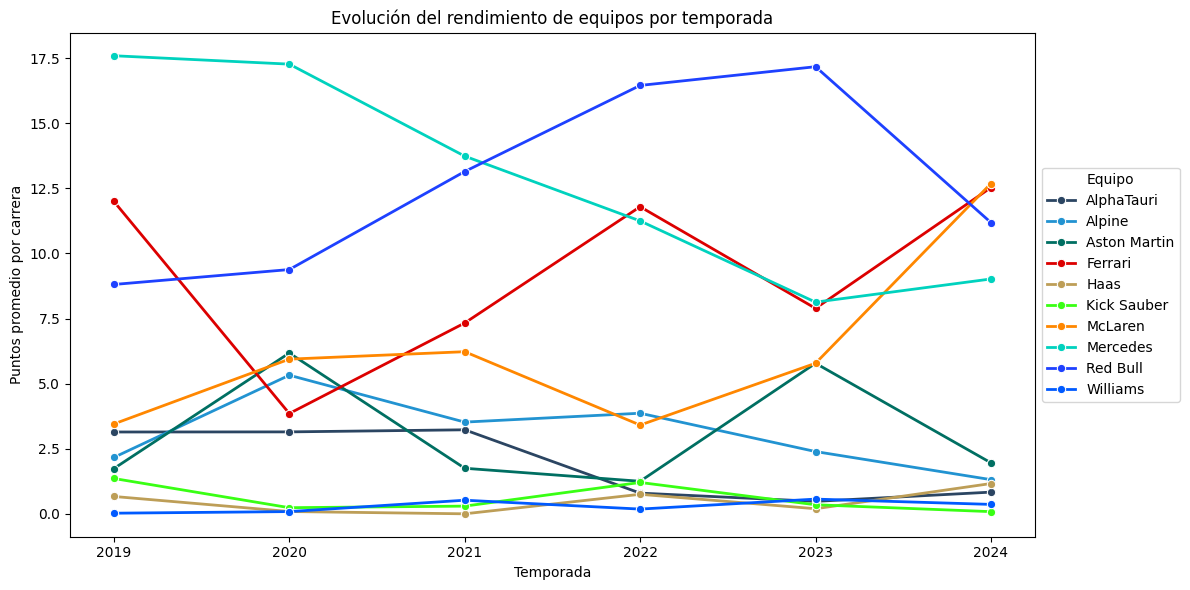

Team,Promedio puntos por carrera,Promedio posición final,Puntos mínimos,Puntos máximos,Posición mínima,Posición máxima
Red Bull,12.86,4.51,0,26,1,19
Mercedes,12.51,4.36,0,26,1,18
Ferrari,9.45,5.43,0,26,1,18
McLaren,6.38,7.62,0,26,1,20
Aston Martin,3.00,9.93,0,25,1,20
Alpine,2.98,9.72,0,25,1,19
AlphaTauri,1.85,11.24,0,25,1,19
Kick Sauber,0.59,13.23,0,12,4,20
Haas,0.50,14.02,0,10,5,20
Williams,0.30,14.37,0,9,2,20


In [33]:
# Promedio de puntos por carrera por Season y Team
df_equipos = df_races_merged.groupby(['Season','Team']).agg(
    race_points=('race_points','mean')
).reset_index()

df_races_merged = pd.merge(
    df_races,
    df_teams[['Team_SeasonID','Team']],
    on='Team_SeasonID',
    how='left'
)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=df_equipos,
    x='Season',
    y='race_points',
    hue='Team',
    marker='o',
    linewidth=2,
    palette=team_colors
)
plt.ylabel("Puntos promedio por carrera")
plt.xlabel("Temporada")
plt.title("Evolución del rendimiento de equipos por temporada")

# Para mover la leyenda afuera del gráfico
plt.legend(title="Equipo", loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()  
plt.show()

# Agrupar por equipo mostrando promedio de puntos y promedio de posición
resumen_equipos = df_races_merged.groupby('Team').agg(
    **{
        'Promedio puntos por carrera': ('race_points','mean'),
        'Promedio posición final': ('race_end_position','mean'),
        'Puntos mínimos': ('race_points','min'),
        'Puntos máximos': ('race_points','max'),
        'Posición mínima': ('race_end_position','min'),
        'Posición máxima': ('race_end_position','max')
    }
).reset_index()

# Redondear a 2 decimales
resumen_equipos = resumen_equipos.round(2)

# Ordenar por promedio de puntos y reiniciar índice
resumen_equipos = resumen_equipos.sort_values('Promedio puntos por carrera', ascending=False).reset_index(drop=True)

resumen_equipos.style.hide(axis="index").format({
    "Promedio puntos por carrera": "{:.2f}",
    "Promedio posición final": "{:.2f}",
    "Puntos mínimos": "{:.0f}",
    "Puntos máximos": "{:.0f}",
    "Posición mínima": "{:.0f}",
    "Posición máxima": "{:.0f}"
})



## 4️⃣ Evolución del rendimiento de equipos por temporada

**Pregunta:** ¿Cómo evolucionaron los equipos en términos de podios, poles y puntos a lo largo de 2019–2024?  
**Hipótesis:** El rendimiento de ciertos equipos se mantiene estable entre temporadas, mientras otros muestran una tendencia de mejora o retroceso.  

**Interpretación del lineplot:**  
- Red Bull y Mercedes presentan los mayores promedios de puntos por carrera (12.86 y 12.51) y las mejores posiciones finales promedio (4.51 y 4.36), mostrando consistencia en rendimiento alto a lo largo de las temporadas.
- Ferrari mantiene un rendimiento intermedio (9.45 puntos promedio, posición final 5.43), relativamente estable, aunque con mayor variabilidad en posiciones finales (1°–18°).
- McLaren y Aston Martin tienen posiciones finales promedio más altas (7.62 y 9.93) y puntos promedio más bajos, indicando desempeño medio-bajo.
- Alpine y AlphaTauri presentan baja puntuación promedio (2.98 y 1.85) y posiciones finales retrasadas (9.72 y 11.24), reflejando resultados menos consistentes.
- Kick Sauber, Haas y Williams muestran los peores promedios, con posiciones finales altas (13–14) y puntos bajos, evidenciando dificultades constantes.
- La variabilidad de posiciones y puntos indica que incluso los equipos punteros pueden tener carreras sobresalientes o muy pobres (ej. Red Bull: mínimo 0, máximo 26).
- En general, se confirma parcialmente la hipótesis: algunos equipos mantienen un rendimiento estable y alto (Red Bull, Mercedes), mientras otros presentan mejoras o retrocesos según temporada, y los equipos con bajo promedio permanecen en bajo rendimiento.